Importing All Required Liabraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import pickle
import sys
from sys import exc_info
import ast

Prepairing Data for Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [ ]:
!cd /content/drive/MyDrive/kaggle

In [ ]:
!kaggle datasets download -d rounakbanik/the-movies-dataset

 91% 208M/228M [00:01<00:00, 199MB/s]
100% 228M/228M [00:01<00:00, 145MB/s]


Rating Dataset

In [107]:
ratings = pd.read_csv('/content/drive/MyDrive/kaggle/ratings.csv', usecols = ['userId', 'movieId','rating'])
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (26024289, 3) 

Max values in dataset are 
 userId     270896.0
movieId    176275.0
rating          5.0
dtype: float64 

Min values in dataset are 
 userId     1.0
movieId    1.0
rating     0.5
dtype: float64 



In [ ]:
ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [108]:
# Filtering data for only 4+ ratings
ratings = ratings[ratings['rating'] >= 4.0]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (12981742, 3) 

Max values in dataset are 
 userId     270896.0
movieId    176271.0
rating          5.0
dtype: float64 

Min values in dataset are 
 userId     1.0
movieId    1.0
rating     4.0
dtype: float64 



 I want to work on a small dataset. So, now we will get a subset of this dataset for only first 5000 movies. Later when we will reduce it further for first 1000 users, then we'll may have less than 5000 movies which has been rated by users and we want to work around 1000 movies.

In [109]:
movies_list = np.unique(ratings['movieId'])[:5000]
ratings = ratings.loc[ratings['movieId'].isin(movies_list)]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')

Shape of ratings dataset is:  (9282654, 3) 

Max values in dataset are 
 userId     270896.0
movieId      5102.0
rating          5.0
dtype: float64 

Min values in dataset are 
 userId     1.0
movieId    1.0
rating     4.0
dtype: float64 



In [110]:
users_list = np.unique(ratings['userId'])[:1000]
ratings = ratings.loc[ratings['userId'].isin(users_list)]
print('Shape of ratings dataset is: ',ratings.shape, '\n')
print('Max values in dataset are \n',ratings.max(), '\n')
print('Min values in dataset are \n',ratings.min(), '\n')
print('Total Users: ', np.unique(ratings['userId']).shape[0])
print('Total Movies which are rated by 1000 users: ', np.unique(ratings['movieId']).shape[0])

Shape of ratings dataset is:  (36114, 3) 

Max values in dataset are 
 userId     1031.0
movieId    5101.0
rating        5.0
dtype: float64 

Min values in dataset are 
 userId     1.0
movieId    1.0
rating     4.0
dtype: float64 

Total Users:  1000
Total Movies which are rated by 1000 users:  2889


Finally We have a dataset of shape (36114,3) which inlcudes 4+ ratings of 2889 movies by 1000 users

we can drop this rating column. we have supposed that each movie which is rated 4+ by user is of his/her interest. So, if a movie is an interest of user 1 then that movie will also be interest of another user 2 of same taste

In [111]:
users_fav_movies = ratings.loc[:, ['userId', 'movieId']]

In [112]:
#Since we were sorted dataframe by columns, so index may not be in proper order.we should reset the index.
users_fav_movies = ratings.reset_index(drop = True)


In [113]:
#Dataframe of first 1000 users favourite movies from the list of first 5000 movies
users_fav_movies.T

,0,1,2,3,4,5,6,7,8,9,...,36104,36105,36106,36107,36108,36109,36110,36111,36112,36113
userId,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1031.0,1031.0,1031.0,1031.0,1031.0,1031.0,1031.0,1031.0,1031.0,1031.0
movieId,147.0,858.0,1221.0,1246.0,1968.0,2762.0,2918.0,2959.0,4226.0,4878.0,...,1196.0,1198.0,2571.0,3481.0,3578.0,3623.0,3755.0,4306.0,4963.0,4993.0
rating,4.5,5.0,5.0,5.0,4.0,4.5,5.0,4.0,4.0,5.0,...,5.0,4.5,4.0,4.0,5.0,4.0,4.5,4.0,5.0,4.0


In [114]:
users_fav_movies.to_csv('/content/drive/MyDrive/kaggle/filtered_ratings.csv') #save this dataframe to csv file on our local

 we create a sparse matrix which we'll use in k-means. For this, let define a function which return us a movies list for each user from dataset

In [115]:
def moviesListForUsers(users, users_data):#returns us a list which will contain strings for each users favourite movies list.
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies
    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['userId'] == user]['movieId'])).split('[')[1].split(']')[0])
    return users_movies_list

In [116]:
users = np.unique(users_fav_movies['userId'])
print(users.shape)

(1000,)


prepair the list of movies list for each user.

In [117]:
users_movies_list = moviesListForUsers(users, users_fav_movies)
print('Movies list for', len(users_movies_list), ' users')
print('A list of first 10 users favourite movies: \n', users_movies_list[:10])

Movies list for 1000  users
A list of first 10 users favourite movies: 
 ['147, 858, 1221, 1246, 1968, 2762, 2918, 2959, 4226, 4878', '64, 79, 260, 339, 377, 605, 628, 648, 1210, 1233, 1356', '527, 858', '223, 415, 648, 1097, 1197, 1221, 1422, 1617, 1645, 1909, 1911, 2023, 2355, 2396, 2443, 2692, 2706, 2716, 2762, 2763, 2875, 2987, 3114, 3160, 3203, 3408, 3476, 3578, 3751, 3753, 3798, 4014, 4238, 4896', '296, 541, 750, 858, 908, 1193, 1198, 1201, 1204, 1225, 1230, 1254, 1263, 1270, 1302, 1945, 2707, 3079, 3114, 3156, 3198', '2565, 2628', '293, 318, 2571, 2858, 2959, 3535, 4022, 4896, 4993', '1, 47, 318, 553, 647, 653, 912, 968, 1210, 1266, 1287, 1292, 1405, 1591, 2019, 2571, 2596, 2670, 2985, 3091, 3175, 3203, 3359, 3527, 3634, 3660, 3679, 3841, 3868, 4443, 4541, 4896, 4956, 4979, 4993, 5008, 5054', '1, 150, 342, 497, 750, 1059, 1183, 1188, 1197, 1207, 1246, 1262, 1527, 1653, 1682, 2321, 2324, 2355, 2395, 2396, 2762, 2858, 3114, 3751, 3793, 3967, 3996, 4014, 4027, 4103, 4226, 4246, 430

Sparse matrix for each user against each movie:

If user has watched movie then 1, else 0

In [118]:
def prepSparseMatrix(list_of_str):
    # list_of_str = A list, which contain strings of users favourite movies separate by comma ",".
    # It will return us sparse matrix and feature names on which sparse matrix is defined
    # i.e. name of movies in the same order as the column of sparse matrix
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names_out()

In [119]:
sparseMatrix, feature_names = prepSparseMatrix(users_movies_list)

In [120]:
df_sparseMatrix = pd.DataFrame(sparseMatrix, index = users, columns = feature_names)
df_sparseMatrix

,1,10,100,1003,1004,1006,1007,1008,1009,101,...,986,987,988,990,991,994,996,997,998,999
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1026,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1030,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
first_10_users_SM = users_fav_movies[users_fav_movies['userId'].isin(users[:10])].sort_values('userId')
first_10_users_SM.T

,0,1,2,3,4,5,6,7,8,9,...,174,173,172,167,170,169,168,176,171,177
userId,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0
movieId,147.0,858.0,1221.0,1246.0,1968.0,2762.0,2918.0,2959.0,4226.0,4878.0,...,588.0,457.0,380.0,150.0,344.0,296.0,165.0,593.0,349.0,595.0
rating,4.5,5.0,5.0,5.0,4.0,4.5,5.0,4.0,4.0,5.0,...,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0


In [ ]:
df_sparseMatrix.loc[np.unique(first_10_users_SM['userId']), list(map(str, np.unique(first_10_users_SM['movieId'])))]

,1,47,64,79,147,150,165,223,260,293,...,4881,4886,4896,4956,4963,4973,4979,4993,5008,5054
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
8,1,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,1,1,1
9,1,0,0,0,0,1,0,0,0,0,...,1,1,0,0,1,1,1,1,0,0
10,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can observe from above two dataframes that our sparse matrix is correct and have values in proper place.


**Clustering Models**


we need to find the optimal number of clusters, we will define an object for elbow method which will contain two functions for run k-means algorithm for different number of clusters and showing plot.

In [ ]:
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()

    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])

    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(visible = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()


In [ ]:
elbow_method = elbowMethod(sparseMatrix)

In [ ]:
elbow_method.run(1, 20)

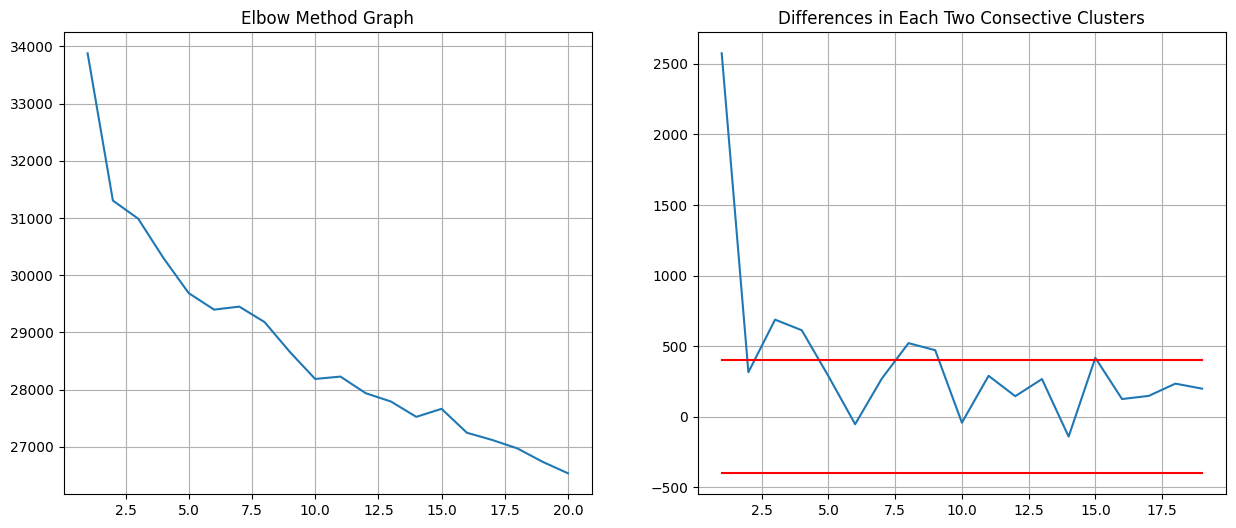

In [ ]:
elbow_method.showPlot(boundary = 400)

We don't have elbow, but we have boundary in differences graph. If we look at the differences graph, we observe that after the cluster 10, the differences are almost inside the boundary.

Fitting data on Model

In [121]:
kmeans = KMeans(n_clusters=10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)

we can see each user cluster number

In [122]:
users_cluster = pd.DataFrame(np.concatenate((users.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['userId', 'Cluster'])
users_cluster.T

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
userId,1,2,3,4,5,6,7,8,9,10,...,1021,1022,1023,1024,1025,1026,1028,1029,1030,1031
Cluster,8,8,8,8,8,8,8,8,5,0,...,8,8,1,8,0,8,8,8,8,5


 will create a list of dataframes where each dataframe will contain the movieId and the counts for that movie

In [123]:
def clustersMovies(users_cluster, users_data):
    clusters = list(users_cluster['Cluster'])
    each_cluster_movies = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(users_cluster[users_cluster['Cluster'] == i]['userId'])
        users_movies_list = list()
        for user in users_list:
            users_movies_list.extend(list(users_data[users_data['userId'] == user]['movieId']))
        users_movies_counts = list()
        users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['movieId', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_movies

In [124]:
cluster_movies = clustersMovies(users_cluster, users_fav_movies)

for example look at this:

In [125]:
cluster_movies[1].T

,0,1,2,3,4,5,6,7,8,9,...,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501
movieId,858,608,1221,1193,296,912,50,750,1252,924,...,3118,3121,1423,1416,3133,1413,3135,3142,1412,5101
Count,31,28,25,25,24,23,23,22,22,22,...,1,1,1,1,1,1,1,1,1,1


We have 1501 movies in 1st cluster where movie with ID 1 is favourite by 31 users

Number of user in each cluster.

In [126]:
for i in range(10):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users)

Users in Cluster 0 ->  84
Users in Cluster 1 ->  33
Users in Cluster 2 ->  1
Users in Cluster 3 ->  33
Users in Cluster 4 ->  1
Users in Cluster 5 ->  169
Users in Cluster 6 ->  1
Users in Cluster 7 ->  1
Users in Cluster 8 ->  676
Users in Cluster 9 ->  1


In [127]:
cluster_movies[2].T

,0,1,2,3,4,5,6,7,8,9,...,323,324,325,326,327,328,329,330,331,332
movieId,11,2657,2611,2599,2598,2570,2554,2504,2496,2493,...,1250,1222,1247,1244,1240,1238,1231,1230,1225,5013
Count,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


As, we can see that there are some clusters which contain only 1 user . we don't want such small cluster where we can't recommend enough movies to users. As the user in a cluster of size one will not get any recommendation for movies . So, we have to fix such small clusters.

we have to move users from small cluster into a large cluster which contain more relavant movies to user,such that at least 33 users in each cluster

In [128]:
# get user favourite movies list
def getMoviesOfUser(user_id, users_data):
    return list(users_data[users_data['userId'] == user_id]['movieId'])

In [129]:
def fixClusters(clusters_movies_dataframes, users_cluster_dataframe, users_data, smallest_cluster_size = 33):
    # clusters_movies_dataframes: will be a list which will contain each dataframes of each cluster movies
    # users_cluster_dataframe: will be a dataframe which contain users IDs and their cluster no.
    # smallest_cluster_size: is a smallest cluster size which we want for a cluster to not remove
    each_cluster_movies = clusters_movies_dataframes.copy()
    users_cluster = users_cluster_dataframe.copy()
    # Let convert dataframe in each_cluster_movies to list with containing only movies IDs
    each_cluster_movies_list = [list(df['movieId']) for df in each_cluster_movies]
    # First we will prepair a list which containt lists of users in each cluster -> [[Cluster 0 Users], [Cluster 1 Users], ... ,[Cluster N Users]]
    usersInClusters = list()
    total_clusters = len(each_cluster_movies)
    for i in range(total_clusters):
        usersInClusters.append(list(users_cluster[users_cluster['Cluster'] == i]['userId']))
    uncategorizedUsers = list()
    i = 0
    # Now we will remove small clusters and put their users into another list named "uncategorizedUsers"
    # Also when we will remove a cluster, then we have also bring back cluster numbers of users which comes after deleting cluster
    # E.g. if we have deleted cluster 4 then their will be users whose clusters will be 5,6,7,..,N. So, we'll bring back those users cluster number to 4,5,6,...,N-1.
    for j in range(total_clusters):
        if len(usersInClusters[i]) < smallest_cluster_size:
            uncategorizedUsers.extend(usersInClusters[i])
            usersInClusters.pop(i)
            each_cluster_movies.pop(i)
            each_cluster_movies_list.pop(i)
            users_cluster.loc[users_cluster['Cluster'] > i, 'Cluster'] -= 1
            i -= 1
        i += 1
    for user in uncategorizedUsers:
        elemProbability = list()
        user_movies = getMoviesOfUser(user, users_data)
        if len(user_movies) == 0:
            print(user)
        user_missed_movies = list()
        for movies_list in each_cluster_movies_list:
            count = 0
            missed_movies = list()
            for movie in user_movies:
                if movie in movies_list:
                    count += 1
                else:
                    missed_movies.append(movie)
            elemProbability.append(count / len(user_movies))
            user_missed_movies.append(missed_movies)
        user_new_cluster = np.array(elemProbability).argmax()
        users_cluster.loc[users_cluster['userId'] == user, 'Cluster'] = user_new_cluster
        if len(user_missed_movies[user_new_cluster]) > 0:
            each_cluster_movies[user_new_cluster] = each_cluster_movies[user_new_cluster].append([{'movieId': new_movie, 'Count': 1} for new_movie in user_missed_movies[user_new_cluster]], ignore_index = True)
    return each_cluster_movies, users_cluster

In [130]:
movies_df_fixed, clusters_fixed = fixClusters(cluster_movies, users_cluster, users_fav_movies, smallest_cluster_size = 20)

<ipython-input-129-1b7e101ef219>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  each_cluster_movies[user_new_cluster] = each_cluster_movies[user_new_cluster].append([{'movieId': new_movie, 'Count': 1} for new_movie in user_missed_movies[user_new_cluster]], ignore_index = True)
<ipython-input-129-1b7e101ef219>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  each_cluster_movies[user_new_cluster] = each_cluster_movies[user_new_cluster].append([{'movieId': new_movie, 'Count': 1} for new_movie in user_missed_movies[user_new_cluster]], ignore_index = True)
<ipython-input-129-1b7e101ef219>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  each_cluster_movies[user_new_cluster] = each_cluster_movies[user_new_cluster].append([{'

In [131]:
j = 0
for i in range(10):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    if len_users < 20:
        print('Users in Cluster ' + str(i) + ' -> ', len_users)
        j += 1
print('Total Cluster which we want to remove -> ', j)

Users in Cluster 2 ->  1
Users in Cluster 4 ->  1
Users in Cluster 6 ->  1
Users in Cluster 7 ->  1
Users in Cluster 9 ->  1
Total Cluster which we want to remove ->  5


In [132]:
print('Length of total clusters before fixing is -> ', len(cluster_movies))
print('Max value in users_cluster dataframe column Cluster is -> ', users_cluster['Cluster'].max())
print('And dataframe is following')
users_cluster.T

Length of total clusters before fixing is ->  10
Max value in users_cluster dataframe column Cluster is ->  9
And dataframe is following


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
userId,1,2,3,4,5,6,7,8,9,10,...,1021,1022,1023,1024,1025,1026,1028,1029,1030,1031
Cluster,8,8,8,8,8,8,8,8,5,0,...,8,8,1,8,0,8,8,8,8,5


In [133]:
print('Length of total clusters after fixing is -> ', len(movies_df_fixed))
print('Max value in users_cluster dataframe column Cluster is -> ', clusters_fixed['Cluster'].max())
print('And fixed dataframe is following')
clusters_fixed.T

Length of total clusters after fixing is ->  5
Max value in users_cluster dataframe column Cluster is ->  4
And fixed dataframe is following


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
userId,1,2,3,4,5,6,7,8,9,10,...,1021,1022,1023,1024,1025,1026,1028,1029,1030,1031
Cluster,4,4,4,4,4,4,4,4,3,0,...,4,4,1,4,0,4,4,4,4,3


In [134]:
print('Size of movies dataframe after fixing -> ', len(movies_df_fixed))

Size of movies dataframe after fixing ->  5


number of user in each cluseter

In [135]:
for i in range(len(movies_df_fixed)):
    len_users = clusters_fixed[clusters_fixed['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users)

Users in Cluster 0 ->  84
Users in Cluster 1 ->  34
Users in Cluster 2 ->  35
Users in Cluster 3 ->  169
Users in Cluster 4 ->  678


number of movie in each cluseter

In [136]:
for i in range(len(movies_df_fixed)):
    print('Total movies in Cluster ' + str(i) + ' -> ', movies_df_fixed[i].shape[0])

Total movies in Cluster 0 ->  987
Total movies in Cluster 1 ->  1564
Total movies in Cluster 2 ->  1720
Total movies in Cluster 3 ->  1607
Total movies in Cluster 4 ->  1828


we need to store this training so that we can use it later

In [137]:
class saveLoadFiles:
    def save(self, filename, data):
        try:
            file = open('/content/drive/MyDrive/ML' + filename + '.pkl', 'wb')
            pickle.dump(data, file)
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            file.close()
            return [True]
    def load(self, filename):
        try:
            file = open('/content/drive/MyDrive/ML' + filename + '.pkl', 'rb')
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            data = pickle.load(file)
            file.close()
            return data
    def loadClusterMoviesDataset(self):
        return self.load('clusters_movies_dataset')
    def saveClusterMoviesDataset(self, data):
        return self.save('clusters_movies_dataset', data)
    def loadUsersClusters(self):
        return self.load('users_clusters')
    def saveUsersClusters(self, data):
        return self.save('users_clusters', data)

Check for loading and saving

In [138]:
saveLoadFile = saveLoadFiles()
print(saveLoadFile.saveClusterMoviesDataset(movies_df_fixed))
print(saveLoadFile.saveUsersClusters(clusters_fixed))

[True]
[True]


In [139]:
load_movies_list, load_users_clusters = saveLoadFile.loadClusterMoviesDataset(), saveLoadFile.loadUsersClusters()
print('Type of Loading list of Movies dataframes of 5 Clusters: ', type(load_movies_list), ' and Length is: ', len(load_movies_list))
print('Type of Loading 1000 Users clusters Data: ', type(load_users_clusters), ' and Shape is: ', load_users_clusters.shape)

Type of Loading list of Movies dataframes of 5 Clusters:  <class 'list'>  and Length is:  5
Type of Loading 1000 Users clusters Data:  <class 'pandas.core.frame.DataFrame'>  and Shape is:  (1000, 2)


We have successfully saved and loaded our data by using pickle liabrary.

**Recommendations For Users**

In [140]:
class userRequestedFor:
    def __init__(self, user_id, users_data):
        self.users_data = users_data.copy()
        self.user_id = user_id
        # Find User Cluster
        users_cluster = saveLoadFiles().loadUsersClusters()
        self.user_cluster = int(users_cluster[users_cluster['userId'] == self.user_id]['Cluster'])
        # Load User Cluster Movies Dataframe
        self.movies_list = saveLoadFiles().loadClusterMoviesDataset()
        self.cluster_movies = self.movies_list[self.user_cluster] # dataframe
        self.cluster_movies_list = list(self.cluster_movies['movieId']) # list
    def updatedFavouriteMoviesList(self, new_movie_Id):
        if new_movie_Id in self.cluster_movies_list:
            self.cluster_movies.loc[self.cluster_movies['movieId'] == new_movie_Id, 'Count'] += 1
        else:
            self.cluster_movies = self.cluster_movies.append([{'movieId':new_movie_Id, 'Count': 1}], ignore_index=True)
        self.cluster_movies.sort_values(by = ['Count'], ascending = False, inplace= True)
        self.movies_list[self.user_cluster] = self.cluster_movies
        saveLoadFiles().saveClusterMoviesDataset(self.movies_list)

    def recommendMostFavouriteMovies(self):
        try:
            user_movies = getMoviesOfUser(self.user_id, self.users_data)
            cluster_movies_list = self.cluster_movies_list.copy()
            for user_movie in user_movies:
                if user_movie in cluster_movies_list:
                    cluster_movies_list.remove(user_movie)
            return [True, cluster_movies_list]
        except KeyError:
            err = "User history does not exist"
            print(err)
            return [False, err]
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            return [False, err]

**Movies_metadata**

import data for not only IDs but for movies details like title, genre etc.

In [141]:
movies_metadata = pd.read_csv(
    '/content/drive/MyDrive/kaggle/movies_metadata.csv',
    usecols = ['id', 'genres', 'original_title'])

movies_metadata = movies_metadata.loc[
    movies_metadata['id'].isin(list(map(str, np.unique(users_fav_movies['movieId']))))].reset_index(drop=True)
print('Let take a look at movie metadata for all those movies which we were had in our dataset')
movies_metadata

Let take a look at movie metadata for all those movies which we were had in our dataset


,genres,id,original_title
0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",949,Heat
1,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",1408,Cutthroat Island
2,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",524,Casino
3,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",5,Four Rooms
4,"[{'id': 14, 'name': 'Fantasy'}, {'id': 878, 'n...",902,La Cité des Enfants Perdus
...,...,...,...
1315,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",2154,The Dark Side of The Moon
1316,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",4049,Die gläserne Zelle
1317,"[{'id': 18, 'name': 'Drama'}]",3178,Beat
1318,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...",2331,Jesus


Here is the list of movies which user with ID 20 has added into its favourite movies

In [142]:
user12Movies = getMoviesOfUser(12, users_fav_movies)
for movie in user12Movies:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Movie title: ', title, ', Genres: [', end = '')
        try:
           genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
           for genre in genres:
               print(genre['name'], ', ', end='')
        except (ValueError, TypeError):
           print(f"Unable to parse genres string: {genres}")
        print(end = '\b\b]')
        print('')

Movie title:  ['Dancer in the Dark'] , Genres: [Drama , Crime , Music , ]
Movie title:  ['The Dark'] , Genres: [Horror , Thriller , Mystery , ]
Movie title:  ['Miami Vice'] , Genres: [Action , Adventure , Crime , Thriller , ]
Movie title:  ['Tron'] , Genres: [Science Fiction , Action , Adventure , ]
Movie title:  ['The Lord of the Rings'] , Genres: [Fantasy , Drama , Animation , Adventure , ]
Movie title:  ['48 Hrs.'] , Genres: [Thriller , Action , Comedy , Crime , Drama , ]
Movie title:  ['Edward Scissorhands'] , Genres: [Fantasy , Drama , Romance , ]
Movie title:  ['Le Grand Bleu'] , Genres: [Adventure , Drama , Romance , ]
Movie title:  ['Saw'] , Genres: [Horror , Mystery , Crime , ]
Movie title:  ["Le fabuleux destin d'Amélie Poulain"] , Genres: [Comedy , Romance , ]
Movie title:  ['Rebecca'] , Genres: [Drama , Mystery , ]
Movie title:  ['Rumble Fish'] , Genres: [Action , Adventure , Crime , Drama , Romance , ]
Movie title:  ['Stand by Me'] , Genres: [Crime 

And finally these are recommended movies for that user

In [144]:
user12Recommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
for movie in user12Recommendations[:20]:
    title = list(movies_metadata.loc[movies_metadata['id'] == str(movie)]['original_title'])
    if title != []:
        print('Movie title: ', title, ', Genres: [', end = '')
        try:
           genres = ast.literal_eval(movies_metadata.loc[movies_metadata['id'] == str(movie)]['genres'].values[0].split('[')[1].split(']')[0])
           for genre in genres:
               print(genre['name'], ', ', end='')
        except (ValueError, TypeError):
           print(f"Unable to parse genres string: {genres}")
        print(']', end = '')
        print()


Movie title:  ['Lonely Hearts'] , Genres: [Drama , Thriller , Crime , Romance , ]
Movie title:  ['Dawn of the Dead'] , Genres: [Fantasy , Horror , Action , ]
Movie title:  ['The Good Shepherd'] , Genres: [Drama , Thriller , History , ]
Movie title:  ['Blood: The Last Vampire'] , Genres: [Fantasy , Animation , Horror , Comedy , Thriller , Science Fiction , ]
Movie title:  ['Dawn of the Dead'] , Genres: [Unable to parse genres string: {'id': 27, 'name': 'Horror'}
]
Movie title:  ['Scarface'] , Genres: [Action , Crime , Drama , Thriller , ]
Movie title:  ['Das wilde Leben'] , Genres: [Music , Drama , Comedy , ]
Movie title:  ['Cold Mountain'] , Genres: [Unable to parse genres string: {'id': 18, 'name': 'Drama'}
]
Movie title:  ['Hannibal Rising'] , Genres: [Crime , Drama , Thriller , ]
Movie title:  ['Street Kings'] , Genres: [Action , Crime , Drama , Thriller , ]
Movie title:  ['The Dreamers'] , Genres: [Drama , Romance , ]
Movie title:  ['The Big Sleep'] , Genres: [Crime , Drama , Myste